### Analyse du 30/03/2024T07

In [1]:
from pathlib import Path
import sunpy.map
from saffron.postprocessing import SPICEL3Raster
from saffron.utils import normit, get_coord_mat
from astropy.visualization import AsymmetricPercentileInterval
from sunpy.physics.differential_rotation import solar_rotate_coordinate
import matplotlib.pyplot as plt
from sunpy.coordinates import frames
import numpy as np

 ChiantiPy version 0.15.1 
 using cli
 using CLI for selections
using ChiantiPy


In [2]:
import sys, os
module_path = os.path.abspath('/home/wmouici/stage/spice-line-fits/linefit_modules')
sys.path.append(module_path)

from linefit_storage import (
    linefit_window_raws, iterdict, linefits,
    write_spice_linefit_file, read_spice_linefit_file,
    create_linefit_window, update_fits)
from skew_parameter_search import simple_lls, detrend_dopp

In [3]:
raster = SPICEL3Raster(folder_path="/home/wmouici/stage/data/saffron_run_results_P3_corrige/solo_L2.5_spice-n-ras_20240330T075931_V22_251658408-000_0600")
radiance_mg = raster.find_line(706).get_map("rad",remove_dumbells=True)
radiance_n = raster.find_line(765).get_map("rad",remove_dumbells=True)
radiance_ne8 = raster.find_line(770).get_map("rad",remove_dumbells=True)

2025-08-21 15:34:32 - sunpy - WARNING: SunpyUserWarning: This file contains more than 2 dimensions. Data will be truncated to the first two dimensions.


Cartes de radiance (magnésium et azote)

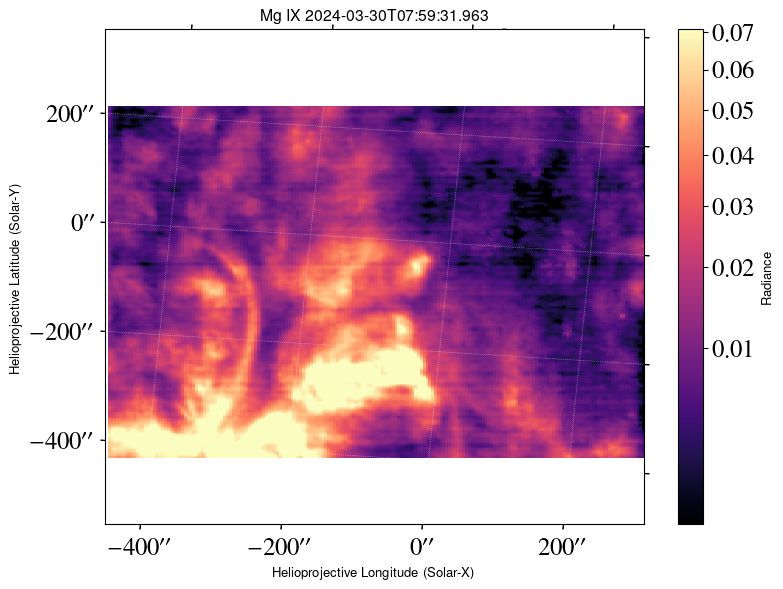

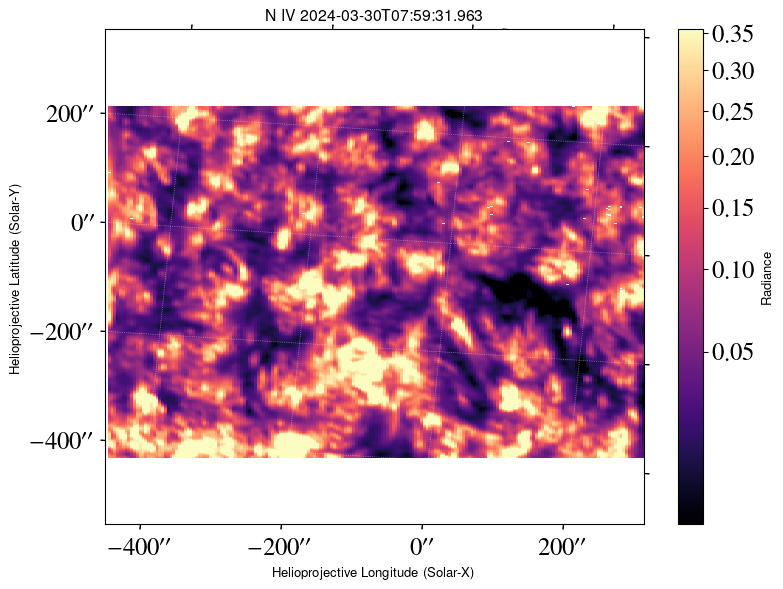

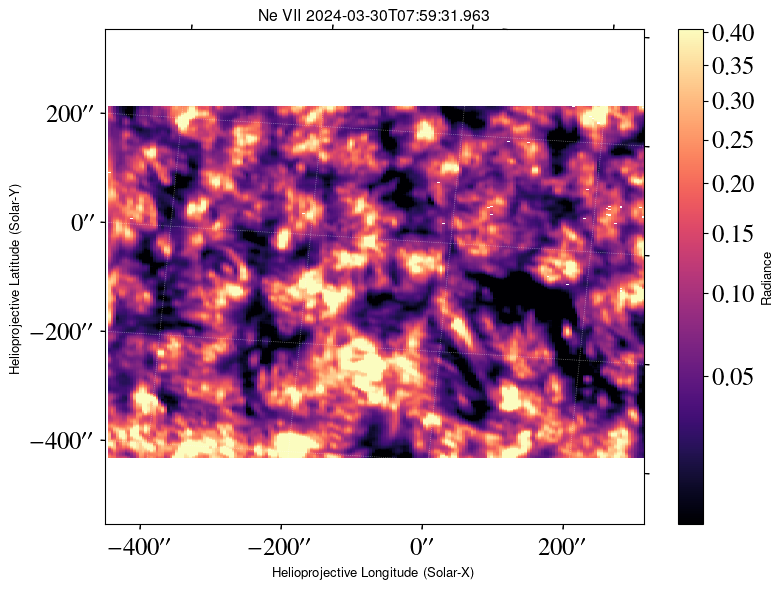

In [4]:
# Normalisation pour un bon contraste
norm = normit(radiance_mg.data, AsymmetricPercentileInterval(1, 95))

plt.figure(figsize=(8, 6))
radiance_mg.plot(norm=norm, cmap='magma')
plt.title(f"Mg IX {radiance_mg.meta.get('date-obs', 'Date inconnue')}", fontsize=12)
plt.colorbar(label="Radiance")
plt.tight_layout()
plt.show()

norm = normit(radiance_n.data, AsymmetricPercentileInterval(1, 95))

plt.figure(figsize=(8, 6))
radiance_n.plot(norm=norm, cmap='magma')
plt.title(f"N IV {radiance_n.meta.get('date-obs', 'Date inconnue')}", fontsize=12)
plt.colorbar(label="Radiance")
plt.tight_layout()
plt.show()

norm = normit(radiance_ne8.data, AsymmetricPercentileInterval(1, 95))

plt.figure(figsize=(8, 6))
radiance_n.plot(norm=norm, cmap='magma')
plt.title(f"Ne VII {radiance_ne8.meta.get('date-obs', 'Date inconnue')}", fontsize=12)
plt.colorbar(label="Radiance")
plt.tight_layout()
plt.show()


Carte de bias FIP

In [5]:
import os 
os.environ["XUVTOP"] = "/home/wmouici/Downloads/CHIANTI_10.1_database"

LFLines = (('s_4', 750), ('s_5', 786))
HFLines = (('n_4', 765.15), ('n_3', 991.59))

/home/wmouici/envs/SAFFRON/lib/python3.11/site-packages/fiplcr/specline/specline.py:116: UserWarning: 0 in interpolated DEM: temperature probably out of range of CHIANTI DEM file
  warnings.warn('0 in interpolated DEM: temperature probably out of range of CHIANTI DEM file')


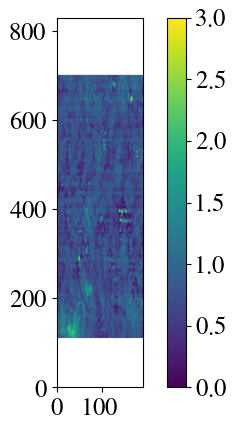

2025-08-21 15:34:38 - sunpy - WARNING: SunpyUserWarning: This file contains more than 2 dimensions. Data will be truncated to the first two dimensions.


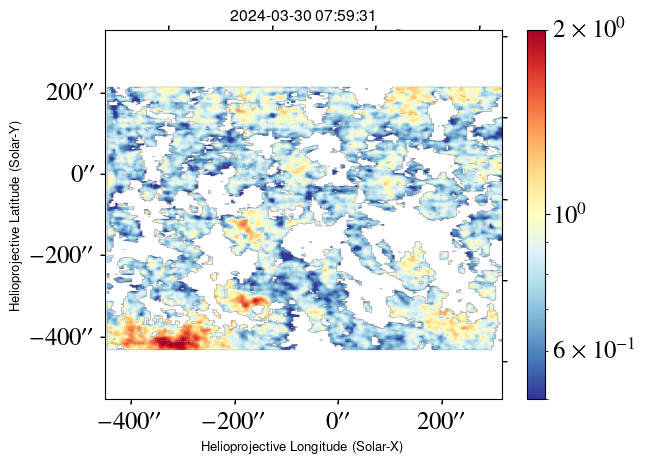

In [6]:
threshold = 0.5

raster.gen_compo_LCR(LFLines=LFLines, HFLines=HFLines)

fip_data = raster.FIP.copy()
fip_err = raster.FIP_err.copy()
# line_750 = raster.find_line(750)
# rad_err_souffre = line_750["rad_err"]
# rad_data_souffre = line_750["rad"]

mask = fip_err > threshold
masked_fip = np.ma.array(fip_data, mask=mask)
fip_map = sunpy.map.Map(masked_fip, raster.FIP_header)
fip_map.plot_settings = {
    "cmap": "RdYlBu_r",
    "norm": plt.matplotlib.colors.LogNorm(1 / 2, 2),
    "aspect": "auto",
}
fip_map.peek()

Contours de bias fip sur les cartes de bias fip sur la radiance et sur les maps FSI

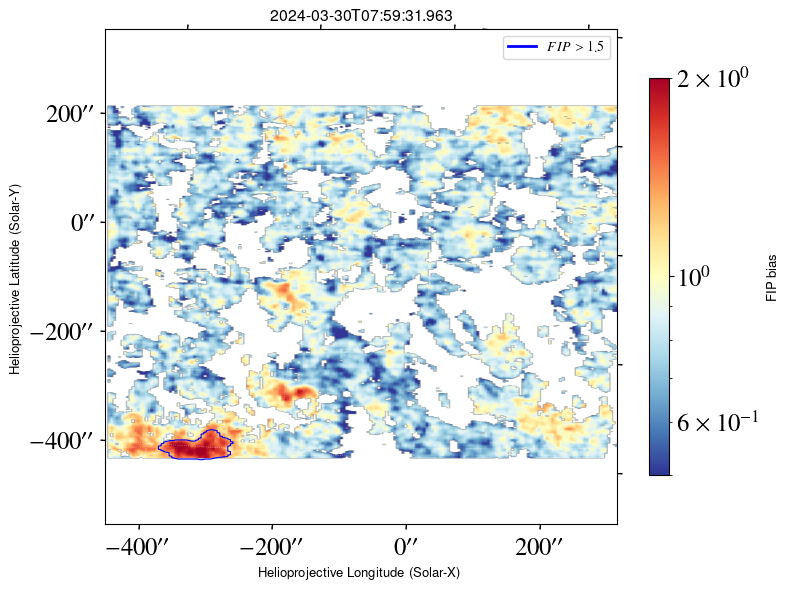

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from scipy.ndimage import gaussian_filter, label, sum as ndi_sum
from matplotlib.lines import Line2D
import sunpy.map

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(projection=fip_map)

norm = colors.LogNorm(0.5, 2)
fip_map.plot_settings['aspect'] = 'auto'
fip_map.plot(axes=ax, norm=norm, cmap="RdYlBu_r")
im = ax.images[0]

masked_data = masked_fip.squeeze()
mask = (~masked_data.mask) & (masked_data.data > 1.5)
mask = mask.astype(float)

smoothed = gaussian_filter(mask, sigma=2)


dense_regions = smoothed > 0.2

label_regions, nb = label(dense_regions)
region_sizes = ndi_sum(dense_regions, label_regions, index=np.arange(1, nb + 1))

min_size = 400
mask_clean = np.zeros_like(dense_regions)
for label_id, size in zip(range(1, nb + 1), region_sizes):
    if size >= min_size:
        mask_clean[label_regions == label_id] = 1

contours= ax.contour(mask_clean, levels=[0.5], colors='blue', linewidths=0.8, transform=ax.get_transform('pixel'))


custom_line = Line2D([0], [0], color='blue', lw=2, label=r'$FIP > 1.5$')
ax.legend(handles=[custom_line], loc='upper right')

cbar = plt.colorbar(im, ax=ax, pad=0.05, shrink=0.8)
cbar.set_label("FIP bias")
ax.set_title(f"{fip_map.meta.get('date-obs', 'Date inconnue')}")
plt.tight_layout()
plt.savefig('/home/wmouici/stage/data/bias_fip_3003.pdf')
plt.show()

In [8]:
import astropy.units as u

arcsec_contours = []

for level_segs in contours.allsegs:  # un niveau = une liste de segments
    for seg in level_segs:           # chaque segment est un tableau (N, 2) : [[x0, y0], ..., [xN, yN]]
        if len(seg) == 0:
            continue

        # Conversion pixels → arcsec
        world_coords = fip_map.pixel_to_world(seg[:, 0]*u.pixel, seg[:, 1]*u.pixel)
        arcsec_contours.append(world_coords)

#print(arcsec_contours[1])

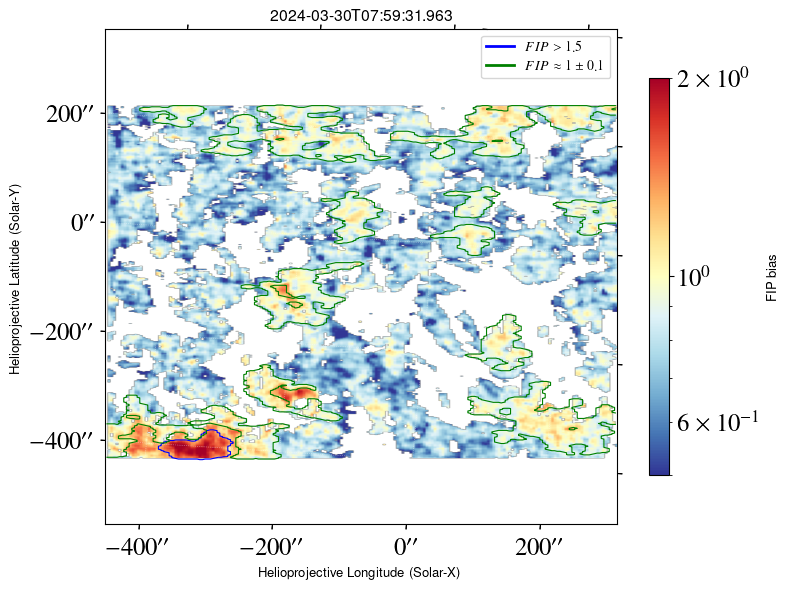

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from scipy.ndimage import gaussian_filter, label, sum as ndi_sum
from matplotlib.lines import Line2D
import sunpy.map

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(projection=fip_map)

# Colormap et normalisation
norm = colors.LogNorm(0.5, 2)
fip_map.plot_settings['aspect'] = 'auto'
fip_map.plot(axes=ax, norm=norm, cmap="RdYlBu_r")
im = ax.images[0]

# Extraction des données masquées
masked_data = masked_fip.squeeze()

# --- Zone FIP > 1.5 ---
mask_high = (~masked_data.mask) & (masked_data.data > 1.5)
smoothed_high = gaussian_filter(mask_high.astype(float), sigma=2)
dense_regions_high = smoothed_high > 0.2
label_high, nb_high = label(dense_regions_high)
region_sizes_high = ndi_sum(dense_regions_high, label_high, index=np.arange(1, nb_high + 1))

mask_clean_high = np.zeros_like(dense_regions_high)
for label_id, size in zip(range(1, nb_high + 1), region_sizes_high):
    if size >= 400:
        mask_clean_high[label_high == label_id] = 1

# --- Zone FIP ≈ 1 ± 0.1 ---
mask_neutral = (~masked_data.mask) & ((masked_data.data >= 0.9) & (masked_data.data <= 1.1))
smoothed_neutral = gaussian_filter(mask_neutral.astype(float), sigma=2)
dense_regions_neutral = smoothed_neutral > 0.2
label_neutral, nb_neutral = label(dense_regions_neutral)
region_sizes_neutral = ndi_sum(dense_regions_neutral, label_neutral, index=np.arange(1, nb_neutral + 1))

mask_clean_neutral = np.zeros_like(dense_regions_neutral)
for label_id, size in zip(range(1, nb_neutral + 1), region_sizes_neutral):
    if size >= 400:
        mask_clean_neutral[label_neutral == label_id] = 1

# Tracer les contours
contours_hf = ax.contour(mask_clean_high, levels=[0.5], colors='blue', linewidths=0.8, transform=ax.get_transform('pixel'))
contours_lf = ax.contour(mask_clean_neutral, levels=[0.5], colors='green', linewidths=0.8, transform=ax.get_transform('pixel'))

# Légende personnalisée
legend_elements = [
    Line2D([0], [0], color='blue', lw=2, label=r'$FIP > 1.5$'),
    Line2D([0], [0], color='green', lw=2, label=r'$FIP \approx 1 \pm 0.1$')
]
ax.legend(handles=legend_elements, loc='upper right')

# Barre de couleur et titre
cbar = plt.colorbar(im, ax=ax, pad=0.05, shrink=0.8)
cbar.set_label("FIP bias")
ax.set_title(f"{fip_map.meta.get('date-obs', 'Date inconnue')}")
plt.tight_layout()
plt.show()


In [10]:
#convert pixel to arcsec
import astropy.units as u
arcsec_contours_hf = []
arcsec_contours_lf = []
for level_segs in contours_hf.allsegs: 
    for seg in level_segs:        
        if len(seg) == 0:
            continue
        world_coords = fip_map.pixel_to_world(seg[:, 0]*u.pixel, seg[:, 1]*u.pixel)
        arcsec_contours_hf.append(world_coords)

for level_segs in contours_lf.allsegs: 
    for seg in level_segs:        
        if len(seg) == 0:
            continue
        world_coords = fip_map.pixel_to_world(seg[:, 0]*u.pixel, seg[:, 1]*u.pixel)
        arcsec_contours_lf.append(world_coords)


#print(arcsec_contours[1])

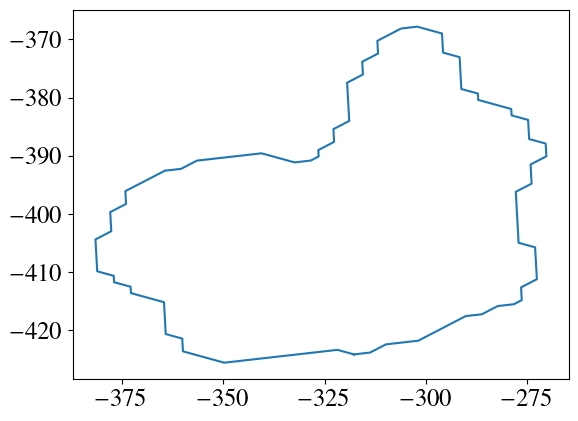

In [11]:
for contour in arcsec_contours_hf:
    plt.plot(contour.Tx.to_value(u.arcsec), contour.Ty.to_value(u.arcsec))
    
plt.show()

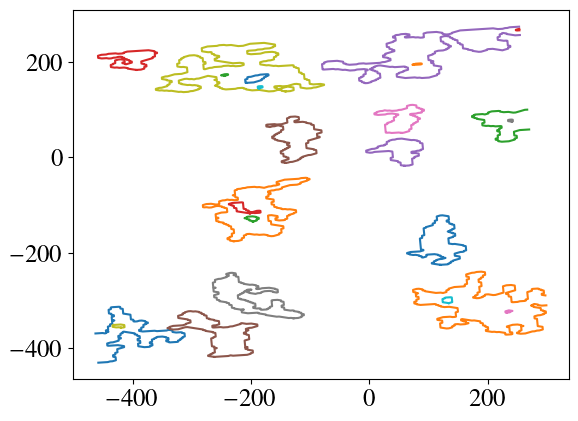

In [12]:
for contour in arcsec_contours_lf:
    plt.plot(contour.Tx.to_value(u.arcsec), contour.Ty.to_value(u.arcsec))
plt.show()

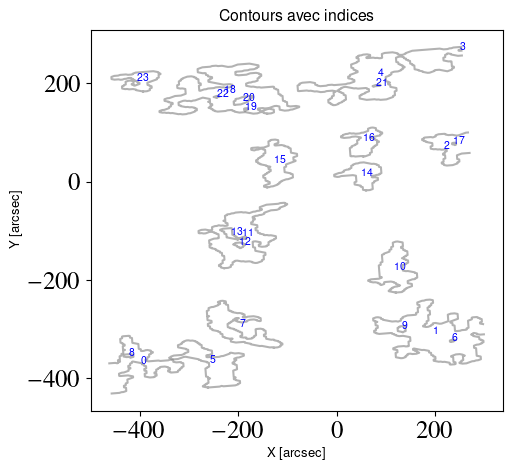

In [13]:
fig, ax = plt.subplots()
for idx, contour in enumerate(arcsec_contours_lf):
    x = contour.Tx.to_value(u.arcsec)
    y = contour.Ty.to_value(u.arcsec)
    ax.plot(x, y, color='gray', alpha=0.6)
    # marquer l'indice au centre du contour
    xm, ym = np.mean(x), np.mean(y)
    ax.text(xm, ym, str(idx), fontsize=8, color='blue')

ax.set_title("Contours avec indices")
ax.set_xlabel("X [arcsec]")
ax.set_ylabel("Y [arcsec]")
ax.set_aspect('equal')
plt.tight_layout()
plt.show()


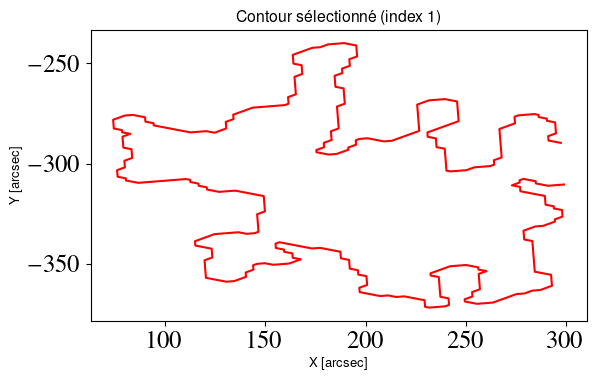

In [14]:
i = 1
contour_low_fip = arcsec_contours_lf[i]

plt.figure()
plt.plot(contour_low_fip.Tx.to_value(u.arcsec), contour_low_fip.Ty.to_value(u.arcsec), color='red')
plt.title(f"Contour sélectionné (index {i})")
plt.xlabel("X [arcsec]")
plt.ylabel("Y [arcsec]")
plt.gca().set_aspect('equal')
plt.show()

Histogramme de valeurs de BIAS FIP sur les régions à haut FIP 

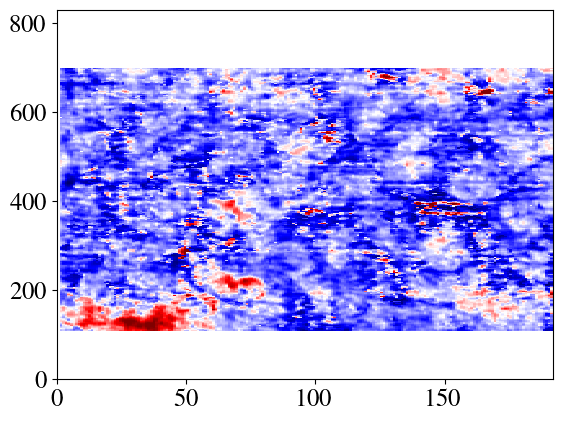

In [15]:
plt.figure()
plt.pcolormesh(fip_map.data,vmin = 0,vmax = 2,cmap = 'seismic')
plt.show()

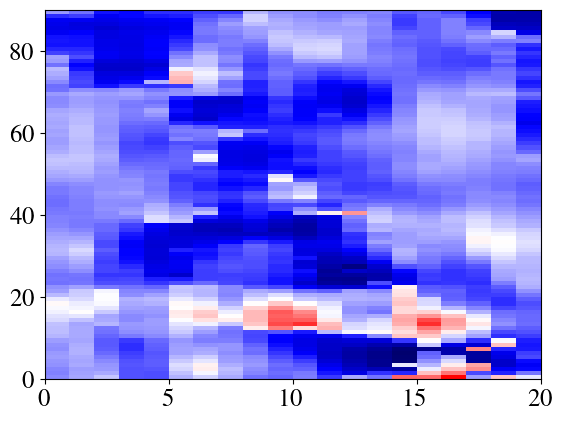

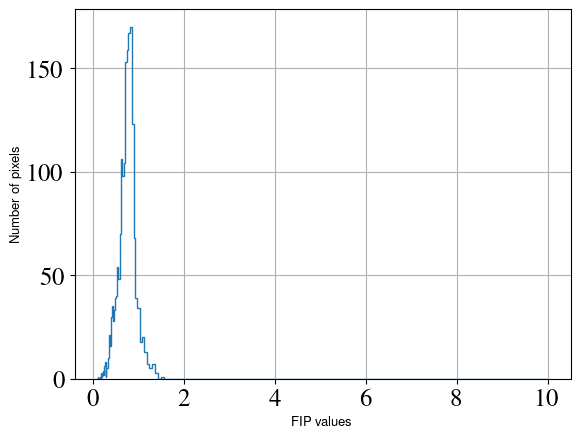

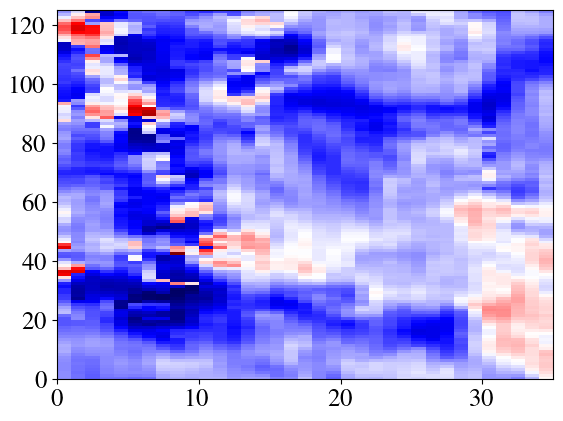

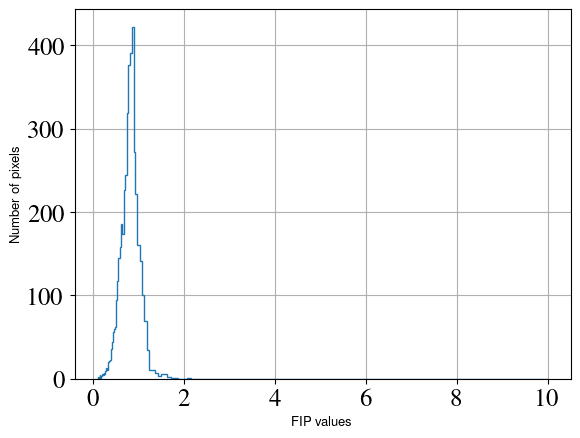

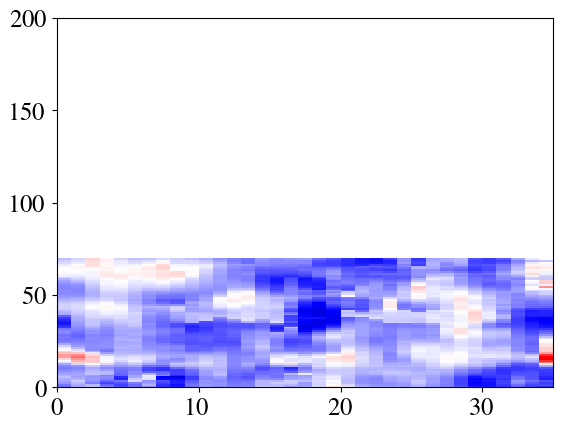

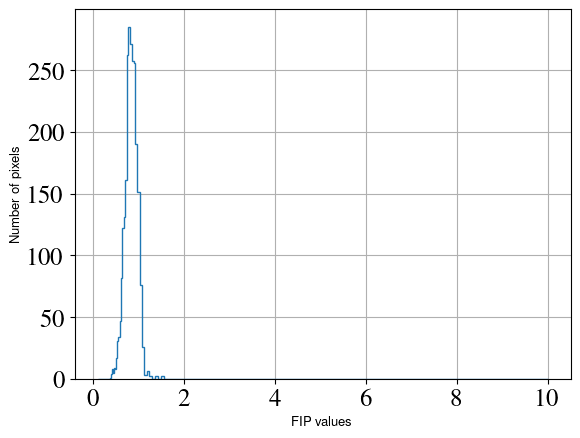

In [16]:
lst_selection = [
    [slice(270,360),slice(110,130)],
    [slice(150,275),slice(125,160)],
    [slice(630,850),slice(25,60)]

]
for (slice_y,slice_x) in lst_selection:

    plt.figure()
    plt.pcolormesh(fip_map.data[slice_y,slice_x],vmin = 0,vmax = 2,cmap = 'seismic')
    plt.show()

    plt.figure()
    plt.hist(fip_map.data[slice_y,slice_x].flatten(),10**np.linspace(-1,1,100),histtype = 'step')
    plt.xlabel("FIP values")
    plt.ylabel('Number of pixels')
    plt.grid()
    plt.show()

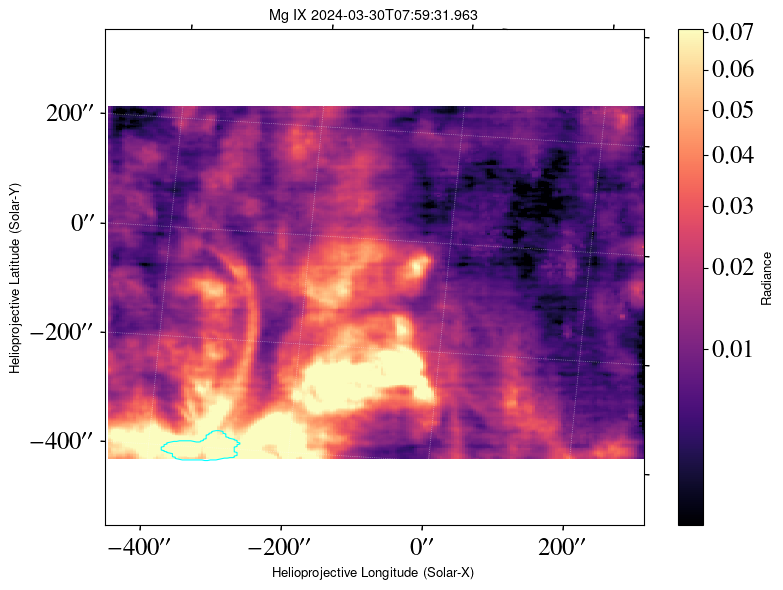

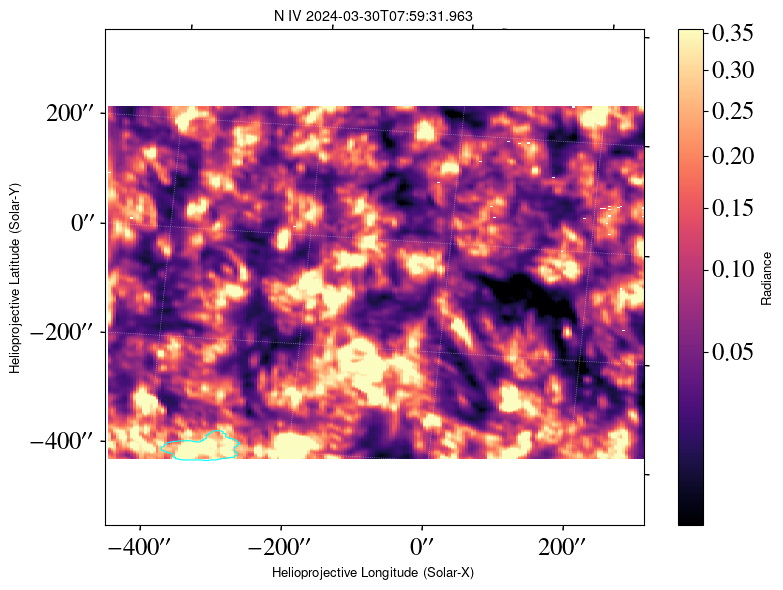

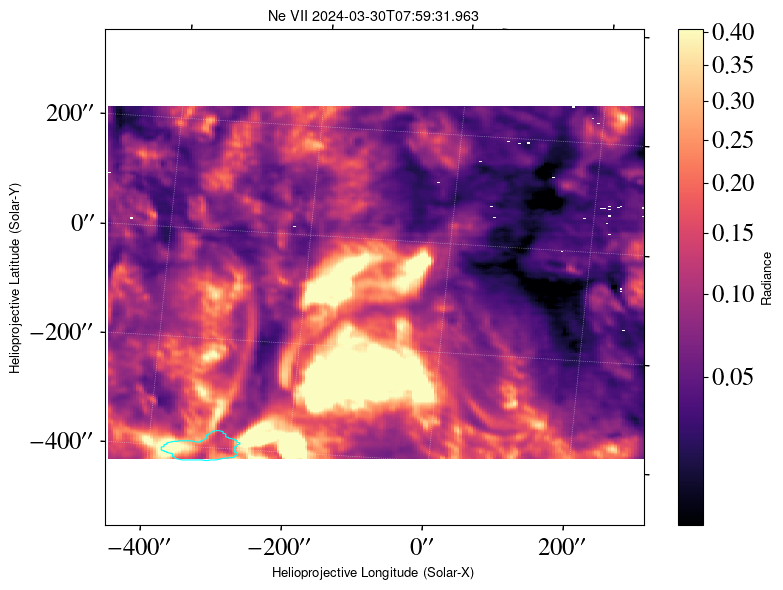

In [17]:
from astropy.visualization import AsymmetricPercentileInterval
from saffron.utils import normit
import matplotlib.pyplot as plt

# Étape 1 : récupérer la carte radiance correspondante
rad_map_mg = radiance_mg
norm = normit(rad_map_mg.data, AsymmetricPercentileInterval(1, 95))

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(projection=rad_map_mg)
rad_map_mg.plot(norm=norm, cmap='magma', axes=ax)

# Superposition des contours
ax.contour(mask_clean, levels=[0.5], colors='cyan', linewidths=0.8, transform=ax.get_transform('pixel'))

# Titre + légende
ax.set_title(f" Mg IX {rad_map_mg.meta.get('date-obs')}", fontsize=11)
plt.colorbar(ax.images[0], ax=ax, label="Radiance")
plt.tight_layout()
plt.show()


# Étape 1 : récupérer la carte radiance correspondante
rad_map_n = radiance_n
norm = normit(rad_map_n.data, AsymmetricPercentileInterval(1, 95))

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(projection=rad_map_n)
rad_map_n.plot(norm=norm, cmap='magma', axes=ax)

# Superposition des contours
ax.contour(mask_clean, levels=[0.5], colors='cyan', linewidths=0.8, transform=ax.get_transform('pixel'))

ax.set_title(f" N IV {rad_map_n.meta.get('date-obs')}", fontsize=11)
plt.colorbar(ax.images[0], ax=ax, label="Radiance")
plt.tight_layout()
plt.show()

# Étape 1 : récupérer la carte radiance correspondante
rad_map_ne8 = radiance_ne8
norm = normit(rad_map_ne8.data, AsymmetricPercentileInterval(1, 95))

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(projection=rad_map_ne8)
rad_map_ne8.plot(norm=norm, cmap='magma', axes=ax)
# Superposition des contours
ax.contour(mask_clean, levels=[0.5], colors='cyan', linewidths=0.8, transform=ax.get_transform('pixel'))
ax.set_title(f" Ne VII {rad_map_ne8.meta.get('date-obs')}", fontsize=11)
plt.colorbar(ax.images[0], ax=ax, label="Radiance")
plt.tight_layout()
plt.show()



### Cartes Doppler

In [18]:
import numpy as np
import sunpy.map
from sunpy.coordinates import frames
from astropy.wcs import WCS
from astropy.nddata import NDData

# # This function, simple_lls, performs a Simple Linear Least Squares (LLS) fit of a linear model 
# # (a sum of basis functions with unknown coefficients) to given data with uncertainties.


# # The SPICE Doppler tend to contain a trend across the image field.
# # Since this will impact the Doppler variance we use to determine which
# # shift is optimal we fit linear trends in x and y and remove them:
def detrend_dopp(dopp, dopp_err): # Remove linear spatial trend in x and y from Doppler
    snr_th = np.abs(dopp) > 2 * np.abs(dopp_err)
    mask = snr_th & (dopp_err > 0)

    nx, ny = dopp.shape
    x0 = np.ones((nx, ny))
    x1, x2 = np.indices((nx, ny))
    x1 = x1 - 0.5 * nx
    x2 = x2 - 0.5 * ny

    mask &= ~np.isnan(dopp)

    cvec = simple_lls(dopp[mask], dopp_err[mask], [x0[mask], x1[mask], x2[mask]])
    dopp_detrend = dopp - x1 * cvec[1] - x2 * cvec[2]
    return dopp_detrend

# def doppler_nddata_to_map(linefit_nddata, err_thold=0.025, conv_factor=1.0, unit=None):
# def doppler_plot(dopp_err_thold=0.025,  doppmin=-0.1, doppmax=0.1, ):
def doppler_map_from_nddata(linefit_nddata, dopp_err_thold=0.025, err_thold=0.025,
                             xmin=0, xmax=None, ymin=0, ymax=None,
                             conv_factor=1.0, unit=None):

    if not isinstance(linefit_nddata, NDData):
        raise TypeError("Expected an NDData object")

    # Extract data
    dopp_data = linefit_nddata.data.squeeze()
    dopp_err = linefit_nddata.uncertainty.array.squeeze()
    metadat = linefit_nddata.meta

    # Default bounds if not specified
    if xmax is None:
        xmax = dopp_data.shape[0]
    if ymax is None:
        ymax = dopp_data.shape[1]

    # Mask on valid errors
    dopp_err_mask = (dopp_err > 0) & (dopp_err < err_thold)

    # Detrend and center the Doppler values
    dopp_detrend = detrend_dopp(dopp_data, dopp_err)
    dopp_center = np.median(dopp_detrend[dopp_err_mask])
    dopp_err_falloff = (dopp_err > 0) * np.clip(err_thold / dopp_err, None, 1) ** 2

    # Apply error-based masking (clip noisy features)
    dopp_errmod = dopp_detrend - dopp_center
    dopp_errmod = np.sign(dopp_errmod) * np.clip(np.abs(dopp_errmod) - np.abs(1.0 * dopp_err), 0, None) + dopp_center

    # Convert units if needed
    if unit is not None:
        dopp_center *= conv_factor
        dopp_errmod *= conv_factor
    else:
        unit = metadat.get('BUNIT', 'unknown')
   # Slice the desired subregion
    submap_data = dopp_errmod[xmin:xmax, ymin:ymax]

    # Build WCS header
    header = metadat.copy()
    header['CUNIT1'] = header.get('CUNIT1', 'arcsec')
    header['CUNIT2'] = header.get('CUNIT2', 'arcsec')
    header['BUNIT'] = unit

    # Adjust CRPIX to account for cropping
    header['NAXIS1'] = submap_data.shape[0]
    header['NAXIS2'] = submap_data.shape[1]
    header['CRPIX1'] -= xmin
    header['CRPIX2'] -= ymin

    wcs = WCS(header)
    doppler_map = sunpy.map.Map(submap_data.T, header)  # Transpose for correct orientation

    return doppler_map


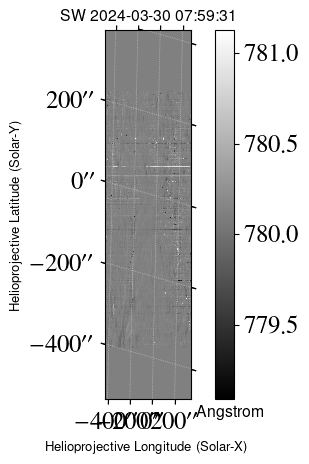

780.207604211
Conversion factor: 384.2470 km/s per Angstrom
Data looks like absolute wavelengths — subtracting rest λ
Doppler map range (km/s): -347.6830935743321 432.73394865362627


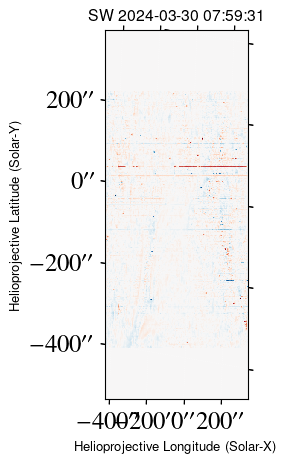

In [32]:
# Path to your FITS file
filename = "/home/wmouici/stage/data/solo_L2_spice-n-ras_20240330T075931_V22_251658408-000psfcorrected_linefits_2.fits"

# from spice_line_fits import read_spice_linefit_file

linefits = read_spice_linefit_file(filename)
line_nd = linefits['Ne VIII 780']['Ne VIII 780']['centers']  # or whatever line you are using 
doppler_map = doppler_map_from_nddata(line_nd)

doppler_map.peek()  # Quick look

# Calculate conversion factor for velocity (Å to km/s)
λ = line_nd.meta['CRVAL3'] * 10  # # Rest wavelength in Angstroms
print(λ)
from astropy.constants import c
# Compute c in km/s
c_kms = c.to('km/s').value  # ≈ 299792.458 km/s

# Conversion factor (km/s per Angstrom)
conv_factor = c_kms / λ
print(f"Conversion factor: {conv_factor:.4f} km/s per Angstrom")

# Get Doppler velocity map
dopp_map = doppler_map_from_nddata(line_nd, conv_factor=conv_factor, unit='km/s')

# print(dopp_map.unit)  # Should report 'km/s'
# print(np.nanmin(dopp_map.data), np.nanmax(dopp_map.data))  # Check velocity range

# print(dopp_map.data)

dopp_map.plot(cmap='RdBu_r', 
                    #  vmin=-20,
                    #  vmax=20, 
                     aspect = 0.6)


# lambda_0 = 976.943963507  # Carbon III rest wavelength
#lambda_0 = 1031.79506351  # O VI rest wavelength
lambda_0  = 780  # N III

# Check if data is absolute or already Δλ
if np.nanmean(line_nd.data) > lambda_0 / 2:
    print("Data looks like absolute wavelengths — subtracting rest λ")
    dopp_shift = line_nd.data - lambda_0
else:
    print("Data looks like wavelength shifts already — using as-is")
    dopp_shift = line_nd.data

# Compute conv factor (km/s per Å)
from astropy.constants import c
c_kms = c.to('km/s').value
conv_factor = c_kms / lambda_0

# Wrap in NDData
from astropy.nddata import NDData
shift_nddata = NDData(data=dopp_shift,
                      uncertainty=line_nd.uncertainty,
                      meta=line_nd.meta)

# Generate Doppler map
doppler_map = doppler_map_from_nddata(shift_nddata,
                                      conv_factor=conv_factor,
                                      unit='km/s')

print("Doppler map range (km/s):", np.nanmin(doppler_map.data), np.nanmax(doppler_map.data))


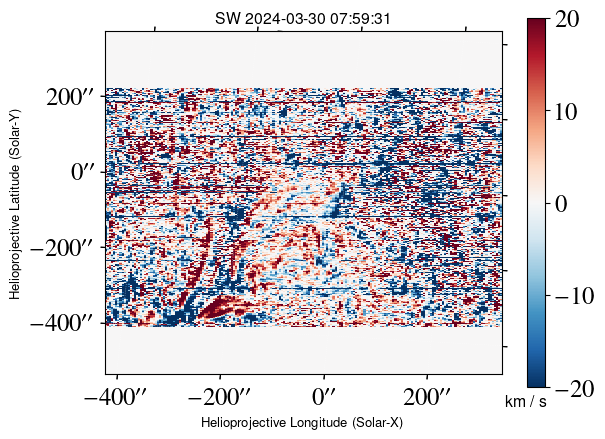

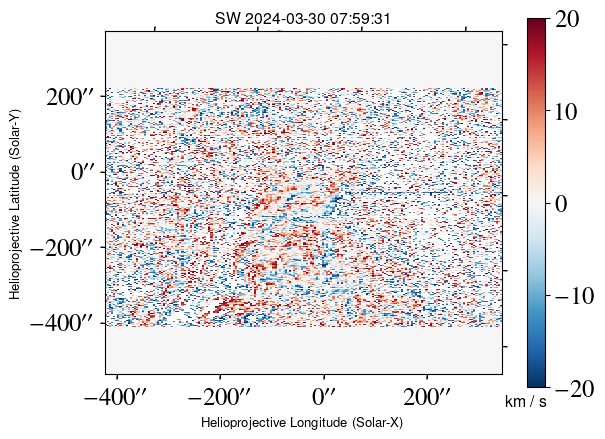

In [33]:
doppler_map_centered = sunpy.map.Map(doppler_map.data - np.nanmedian(doppler_map.data), doppler_map.meta)
doppler_map_centered.peek(vmin=-20, vmax=20, cmap='RdBu_r', aspect = 0.2)

# Define physical Doppler limits (e.g., ±200 km/s)
vmin, vmax = -20, 20

# Apply mask
value_masked_data = np.where((doppler_map_centered.data > vmin) & (doppler_map_centered.data < vmax),
                             doppler_map_centered.data, np.nan)

# Create new map
value_masked_map = sunpy.map.Map(value_masked_data, doppler_map_centered.meta)

value_masked_map.peek(vmin=-20, vmax=20, cmap='RdBu_r', aspect = 0.2)


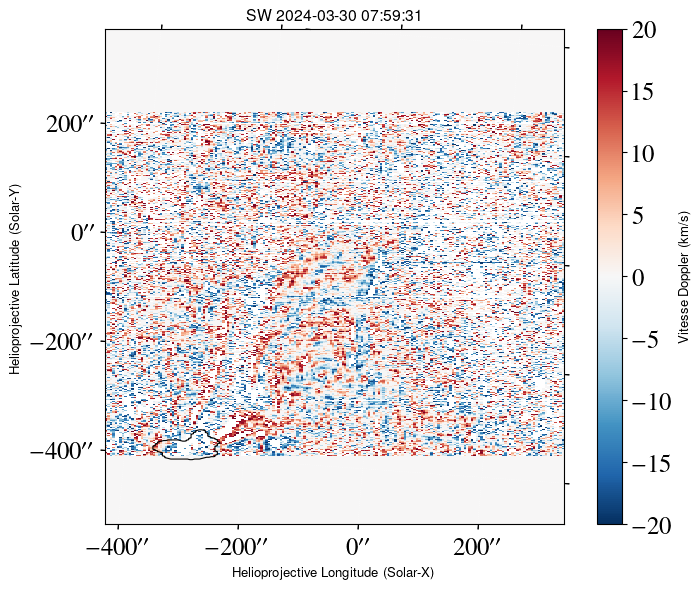

In [34]:
fig = plt.figure(figsize=(8, 6))
ax  = fig.add_subplot(projection=value_masked_map)

value_masked_map.plot(
        cmap='RdBu_r', vmin=-20, vmax=20,
        axes=ax,
        aspect=0.25)        

ax.contour(mask_clean, levels=[0.5],
           colors='black', linewidths=0.8,
           transform=ax.get_transform('pixel'))

plt.colorbar(ax.images[0], ax=ax, label="Vitesse Doppler (km/s)")
plt.tight_layout()
plt.savefig('/home/wmouici/stage/data/doppler_map_3003.pdf')
plt.show()


Contours sur la map FSI 

2025-08-21 15:34:52 - sunpy - WARNING: SunpyUserWarning: This file contains more than 2 dimensions. Data will be truncated to the first two dimensions.


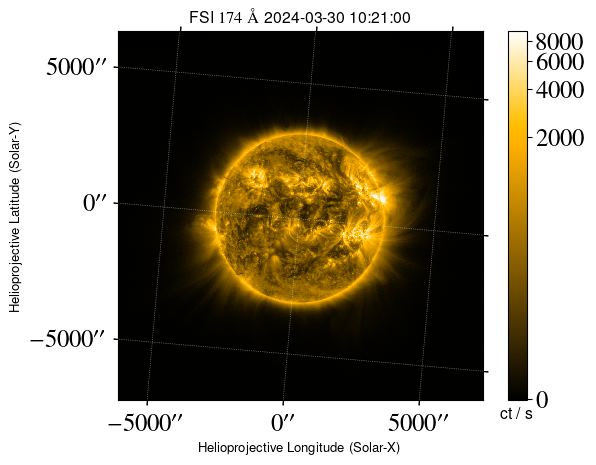

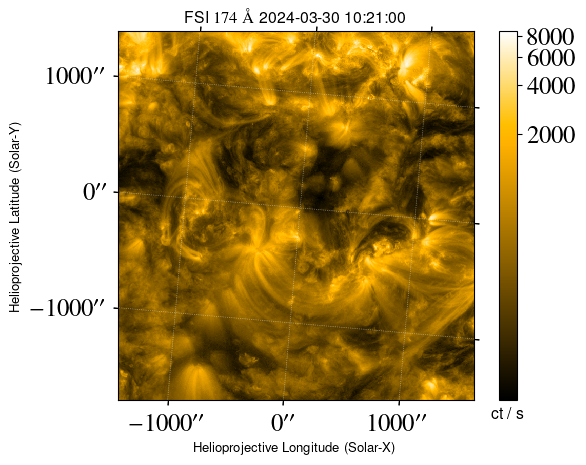

In [22]:
import os.path
from euispice_coreg.hdrshift.alignment import Alignment
import numpy as np
from euispice_coreg.plot.plot import PlotFunctions
from euispice_coreg.utils.Util import AlignCommonUtil
from pathlib import Path
import astropy.units as u
from getmap import to_submap

path_fsi = Path("/archive/SOLAR-ORBITER/EUI/data_internal/L2/2024/03/30/solo_L2_eui-fsi174-image_20240330T102055281_V00.fits")
path_hri = Path("/home/wmouici/stage/data/saffron_run_results_P3_corrige/solo_L2.5_spice-n-ras_20240330T075931_V22_251658408-000_0600/00706.02-mg_9.fits")
if True:
     from astropy.io import fits
     from sunpy.map import Map
     fsi_map = Map(path_fsi)
     tmp_path = Path("./tmp/")
     tmp_path.mkdir(exist_ok=True)
     hdul = fits.open(path_hri)
     data = hdul[0].data*hdul[2].data
     map_ = Map([data,hdul[0].header])
     sub_map = to_submap(target_map=fsi_map,source_map=map_,expand=[1000,1000]*u.arcsec)
     #
     # 
     # .save(tmp_path/path_fsi.name,overwrite=True)
     # map_.save(tmp_path/path_hri.name,overwrite=True)
     # path_hri = str(tmp_path/path_hri.name)
     # path_fsi = str(tmp_path/path_fsi.name)

fsi_map.peek()
sub_map.peek()

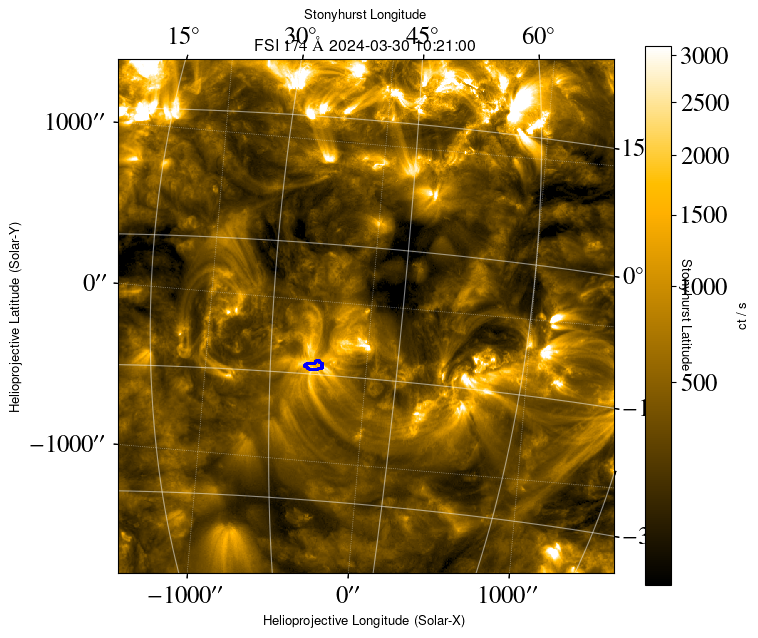

In [23]:
from sunpy.physics.differential_rotation import solar_rotate_coordinate
import matplotlib.pyplot as plt
from sunpy.visualization.colormaps import color_tables as ct
from matplotlib import colors


# observer_fsi = sub_map.observer_coordinate
# rotated_contours_to_submap = []
# for contour in arcsec_contours_lf[1]:
#     rotated = solar_rotate_coordinate(contour, observer=observer_fsi)
#     rotated_contours_to_submap.append(rotated)


fig = plt.figure(figsize=(8, 7))
ax = fig.add_subplot(projection=sub_map)

norm = normit(sub_map.data, AsymmetricPercentileInterval(1, 99))

sub_map.plot(axes=ax, cmap='sdoaia171', norm=norm)

sub_map.draw_grid(axes=ax)

# for contour in arcsec_contours_lf[1]:
#     ax.plot_coord(contour, color='blue', linewidth=1.5)
# ax.plot_coord(contour_low_fip, color='blue', linewidth=1.5)

for contours in arcsec_contours_hf:
    ax.plot_coord(contours, color='blue', marker='o', linewidth=0, markersize=1)
cbar = plt.colorbar(ax.get_images()[0], ax=ax, pad=0.05)
cbar.set_label(sub_map.unit.to_string())
plt.savefig('/home/wmouici/stage/data/fsi_map_3003.pdf')
plt.show()


Contours sur la map AIA

In [24]:
if not os.path.exists('aia_map_20240330.fits'):
    import urllib.request
    urllib.request.urlretrieve(
        'http://jsoc2.stanford.edu/data/aia/synoptic/2024/03/30/H0700/AIA20240330_0700_0193.fits',
        'aia_map_20240330.fits')

aia = sunpy.map.Map('aia_map_20240330.fits')
dtime = aia.date

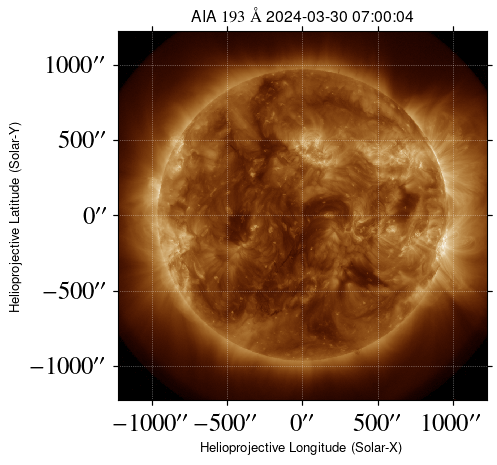

In [25]:
ax = plt.subplot(1, 1, 1, projection=aia)
aia.plot(axes=ax)

In [26]:
from sunpy.physics.differential_rotation import solar_rotate_coordinate
from sunpy.coordinates import get_body_heliographic_stonyhurst

from astropy.time import Time

# Observer de la Terre au moment de l'image AIA
observer_earth = get_body_heliographic_stonyhurst("earth", aia.date)

rotated_arcsec_contours = []

for contour in arcsec_contours:
    # Rotation solaire + projection vers le point de vue Terre
    contour_rot = solar_rotate_coordinate(contour, observer=observer_earth)
    rotated_arcsec_contours.append(contour_rot)

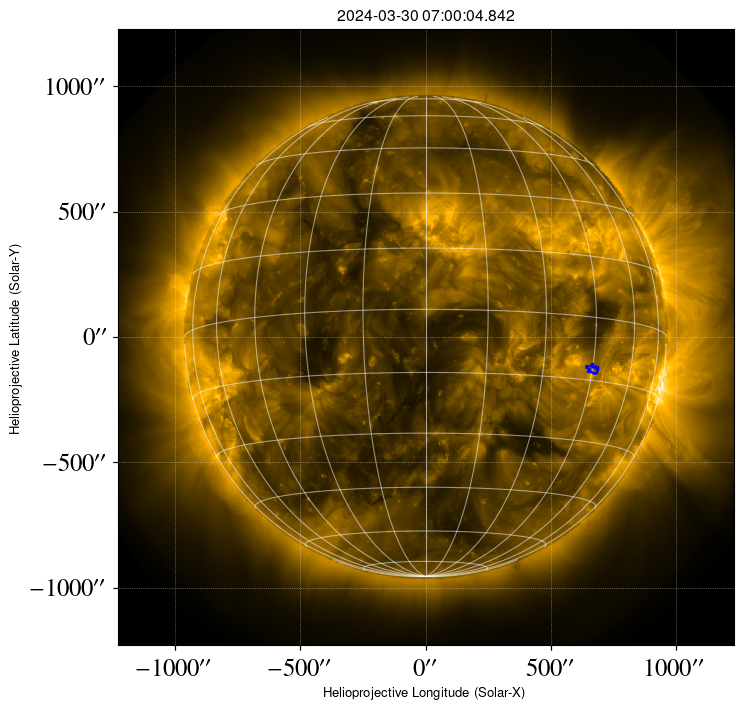

In [27]:

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection=aia)

aia.plot(axes=ax, cmap='sdoaia171')  # ou ton canal
# aia.draw_limb(axes=ax)
aia.draw_grid(axes=ax)

# # Affichage des contours projetés
# for contour in arcsec_contours:
#     ax.plot_coord(contour, color='blue', linewidth=1.2)

ax.plot_coord(contour_low_fip, color='blue', linewidth=1.2)

plt.title(f"{aia.date.iso}")
plt.show()

### PFSS sur les régions LF et HF

In [28]:
import os
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
import sunpy.map
from astropy.coordinates import SkyCoord

import pfsspy
import pfsspy.tracing as tracing
from pfsspy.sample_data import get_gong_map
import urllib.request

gong_map = sunpy.map.Map('/home/wmouici/stage/data/mrbqs240330t0704c2282_071.fits')

# Patch si les unités ne sont pas dans le header
if 'cunit1' not in gong_map.meta:
    gong_map.meta['cunit1'] = 'deg'
if 'cunit2' not in gong_map.meta:
    gong_map.meta['cunit2'] = 'deg'

In [29]:
nrho = 25
rss = 2.5
pfss_in = pfsspy.Input(gong_map, nrho, rss)

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


2025-08-21 15:35:01 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.


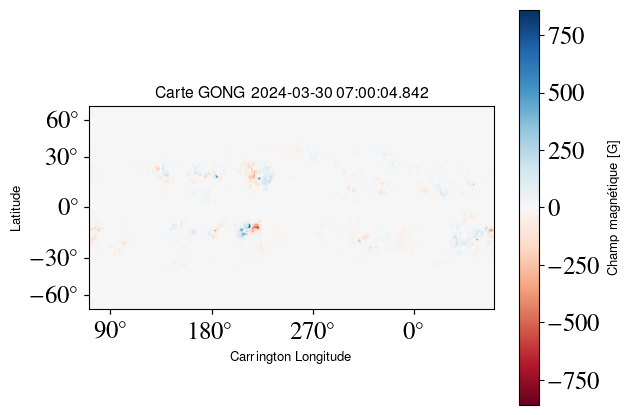

In [30]:
m = pfss_in.map

fig = plt.figure()
ax = plt.subplot(projection=m)

# Récupération de l'image pour associer la colorbar
im = m.plot(axes=ax)

# Création de la colorbar liée à cette image

cbar = plt.colorbar(im, ax=ax)
cbar.set_label(f'Champ magnétique [{m.unit}]')

ax.set_title(f'Carte GONG {dtime.iso}', fontsize=12)
plt.tight_layout()
plt.show()

In [31]:
pfss_out = pfsspy.pfss(pfss_in)

SystemError: CPUDispatcher(<function _eigh at 0x7f8b164132e0>) returned a result with an exception set

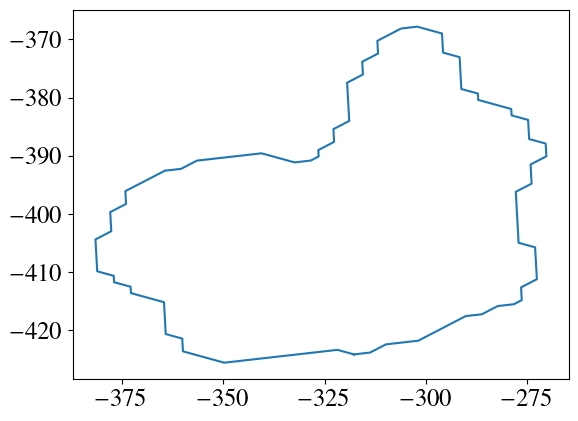

In [ ]:
for contour in arcsec_contours:
    plt.plot(contour.Tx.to_value(u.arcsec),contour.Ty.to_value(u.arcsec))

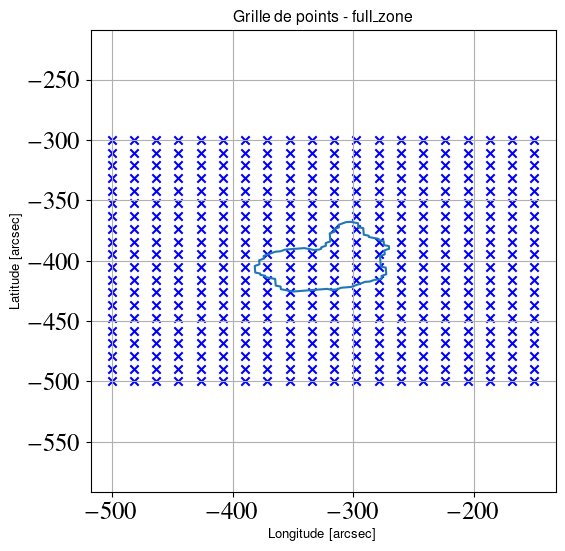

In [ ]:
from astropy.coordinates import SkyCoord

hp_lon = np.linspace(-500, -150, 20) * u.arcsec
hp_lat = np.linspace(-500, -300, 20) * u.arcsec
lon, lat = np.meshgrid(hp_lon, hp_lat)
full_zone = SkyCoord(lon.ravel(), lat.ravel(),
                 frame=fsi_map.coordinate_frame)
lon_arcsec = full_zone.Tx.to_value(u.arcsec)
lat_arcsec = full_zone.Ty.to_value(u.arcsec)

plt.figure(figsize=(6, 6))
plt.scatter(lon_arcsec, lat_arcsec, marker='x', color='blue')

for contour in arcsec_contours:
    plt.plot(contour.Tx.to_value(u.arcsec), contour.Ty.to_value(u.arcsec))

# plt.plot(contour_low_fip.Tx.to_value(u.arcsec), contour_low_fip.Ty.to_value(u.arcsec))

plt.xlabel("Longitude [arcsec]")
plt.ylabel("Latitude [arcsec]")
plt.title("Grille de points - full_zone")
plt.grid(True)
plt.axis("equal")
plt.show()

/tmp/ipykernel_3082412/2119508081.py:35: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


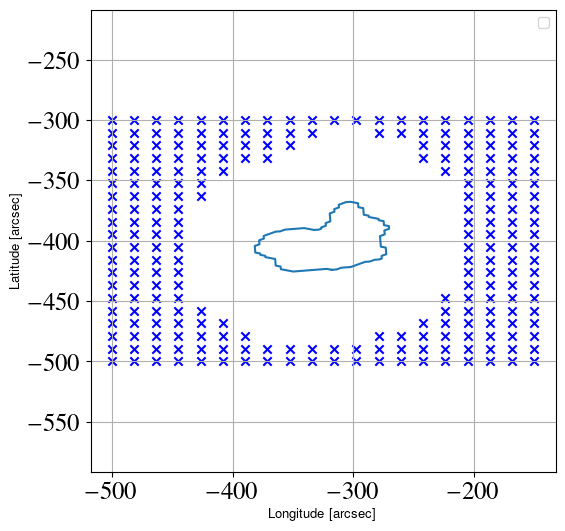

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon

x = full_zone.Tx.to_value(u.arcsec)
y = full_zone.Ty.to_value(u.arcsec)
points = list(zip(x, y))

buffer = 60
polygons = []

for contour in arcsec_contours:
    coords = list(zip(contour.Tx.to_value(u.arcsec), contour.Ty.to_value(u.arcsec)))
    poly = Polygon(coords).buffer(buffer)
    polygons.append(poly)

points_outside = []
for pt in points:
    point = Point(pt)
    inside = any(poly.contains(point) for poly in polygons)
    if not inside:
        points_outside.append(pt)

x_out, y_out = zip(*points_outside)

plt.figure(figsize=(6, 6))
plt.scatter(x_out, y_out, color='blue', marker='x')
for contour in arcsec_contours:
    plt.plot(contour.Tx.to_value(u.arcsec), contour.Ty.to_value(u.arcsec))
plt.xlabel("Longitude [arcsec]")
plt.ylabel("Latitude [arcsec]")

plt.axis("equal")
plt.grid(True)
plt.legend()
#plt.ylim(-200,300)
plt.show()


/tmp/ipykernel_3082412/205442720.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


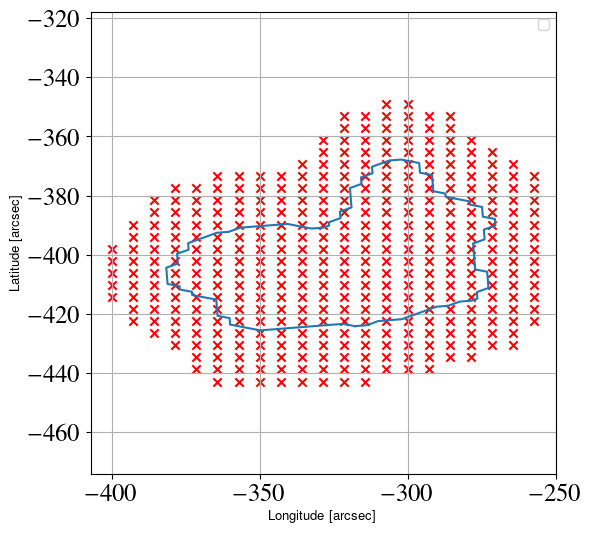

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon
from astropy.coordinates import SkyCoord
import astropy.units as u

x = full_zone.Tx.to_value(u.arcsec)
y = full_zone.Ty.to_value(u.arcsec)
points = list(zip(x, y))

buffer = 20 
polygons = []
for contour in arcsec_contours:
    coords = list(zip(contour.Tx.to_value(u.arcsec), contour.Ty.to_value(u.arcsec)))
    poly = Polygon(coords).buffer(buffer)
    polygons.append(poly)

# coords = list(zip(contour_low_fip.Tx.to_value(u.arcsec), contour_low_fip.Ty.to_value(u.arcsec)))
# poly = Polygon(coords).buffer(buffer)
# polygons.append(poly)

points_inside = []
for pt in points:
    point = Point(pt)
    if any(poly.contains(point) for poly in polygons):
        points_inside.append(pt)

x_in, y_in = zip(*points_inside)

plt.figure(figsize=(6, 6))
plt.scatter(x_in, y_in, color='red', marker='x')
for contour in arcsec_contours:
    plt.plot(contour.Tx.to_value(u.arcsec), contour.Ty.to_value(u.arcsec))

# for contour in contour_low_fip:
#     plt.plot(contour.Tx.to_value(u.arcsec), contour.Ty.to_value(u.arcsec))

# plt.plot(contour_low_fip.Tx.to_value(u.arcsec), contour_low_fip.Ty.to_value(u.arcsec))
plt.xlabel("Longitude [arcsec]")
plt.ylabel("Latitude [arcsec]")
plt.grid(True)
plt.axis("equal")
plt.legend()
plt.show()

In [ ]:
points_outside_coord = SkyCoord(x_out*u.arcsec, y_out*u.arcsec,frame=fsi_map.coordinate_frame)



In [ ]:
points_inside_coord = SkyCoord(x_in * u.arcsec, y_in * u.arcsec, frame=fsi_map.coordinate_frame)

In [ ]:
from sunpy.physics.differential_rotation import solar_rotate_coordinate
from sunpy.coordinates import get_body_heliographic_stonyhurst
from astropy.time import Time

# Observer de la Terre au moment de l'image AIA
observer_earth = get_body_heliographic_stonyhurst("earth", fsi_map.date)
rotated_full_zone = []

for contour in points_inside_coord:
    # Rotation solaire + projection vers le point de vue Terre
    contour_rot = solar_rotate_coordinate(contour, observer=observer_earth)
    rotated_full_zone.append(contour_rot)


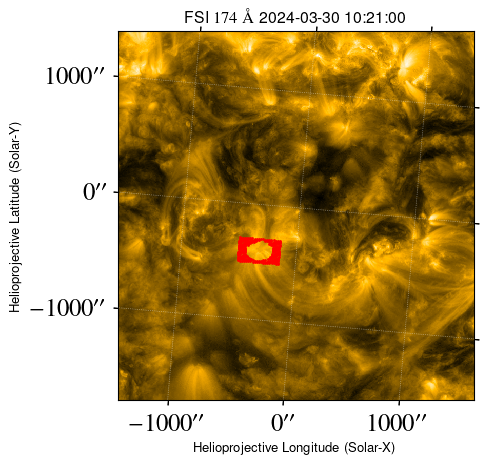

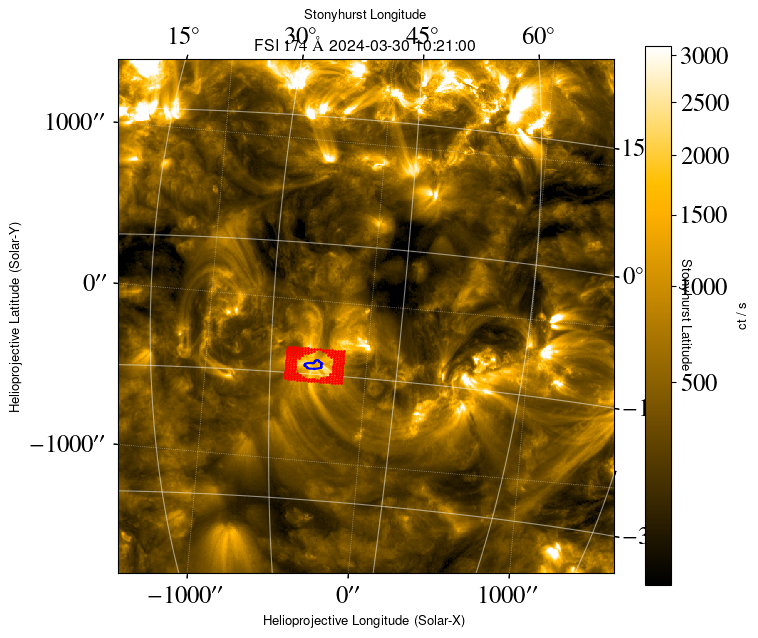

In [ ]:
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt

zone_list = []
for contour in points_outside_coord:
    zone = SkyCoord(contour.Tx, contour.Ty, frame=sub_map.coordinate_frame)
    zone_list.append(zone)

fig = plt.figure()
ax = plt.subplot(projection=sub_map)
sub_map.plot(axes=ax)

for zone in zone_list:
    ax.plot_coord(zone, color='red', marker='o', linewidth=0, markersize=1)

# for contours in arcsec_contours:
#     ax.plot_coord(contours, color='blue', marker='o', linewidth=0, markersize=1)

# ax.plot_coord(contour_low_fip, color='blue', marker='o', linewidth=0, markersize=1)
# plt.tight_layout()
# plt.show()

fig = plt.figure(figsize=(8, 7))
ax = fig.add_subplot(projection=sub_map)

norm = normit(sub_map.data, AsymmetricPercentileInterval(1, 99))
sub_map.plot(axes=ax, cmap='sdoaia171', norm=norm)

sub_map.draw_grid(axes=ax)
for zone in zone_list:
    ax.plot_coord(zone, color='red', marker='o', linewidth=0, markersize=1)
for contour in arcsec_contours:
    ax.plot_coord(contour, color='blue', linewidth=1.5)
cbar = plt.colorbar(ax.get_images()[0], ax=ax, pad=0.05)
cbar.set_label(sub_map.unit.to_string())
plt.show()


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


2025-08-14 10:41:20 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.


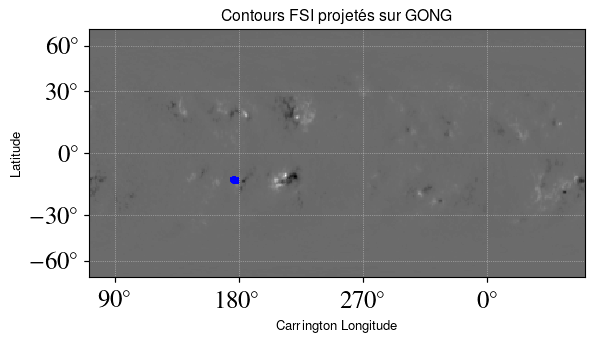

In [ ]:
fig = plt.figure()
ax = plt.subplot(projection=gong_map)  # GONG en Carrington

# Plotte la carte de champ
gong_map.plot(axes=ax)

# Les seeds : doivent être en coordonnées FSI
for contour in zone_list:
    coord = SkyCoord(contour.Tx, contour.Ty, frame=fsi_map.coordinate_frame)
    ax.plot_coord(coord, color='blue', linewidth=0, marker='o', markersize=1)

ax.set_title("Contours FSI projetés sur GONG")
plt.show()


In [ ]:
import numpy as np
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.time import Time
from sunpy.coordinates.frames import HeliographicCarrington
from sunpy.coordinates import Helioprojective

x_all = []
y_all = []

for z in zone_list:
    x_all.append(z.Tx.to_value(u.arcsec))
    y_all.append(z.Ty.to_value(u.arcsec))

x_centre = np.mean(x_all) * u.arcsec
y_centre = np.mean(y_all) * u.arcsec

frame = Helioprojective(observer=fsi_map.observer_coordinate,
                        rsun=fsi_map.coordinate_frame.rsun,
                        obstime=Time("2023-10-18T03:14:35"))

point_central = SkyCoord(x_centre, y_centre, frame=frame)


point_carr = point_central.transform_to(
    HeliographicCarrington(observer='earth', obstime=point_central.obstime)
)

print(f"Longitude carringotn: {point_carr.lon:.2f}")



Longitude carringotn: 344.88 deg


In [ ]:
tracer = tracing.FortranTracer()
tracer = tracing.FortranTracer()
flines_list_full = [tracer.trace(zone, pfss_out) for zone in zone_list]

In [ ]:
expansion_factors_full = []

for fieldline_group in flines_list_full:
    for fl in fieldline_group.field_lines:
        expansion_factors_full.append(fl.expansion_factor)


In [ ]:
print(len(expansion_factors_full))
print(np.sum(np.isnan(expansion_factors_full)))

780
780


/home/wmouici/envs/SAFFRON/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7096: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/home/wmouici/envs/SAFFRON/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7097: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


ValueError: autodetected range of [nan, nan] is not finite

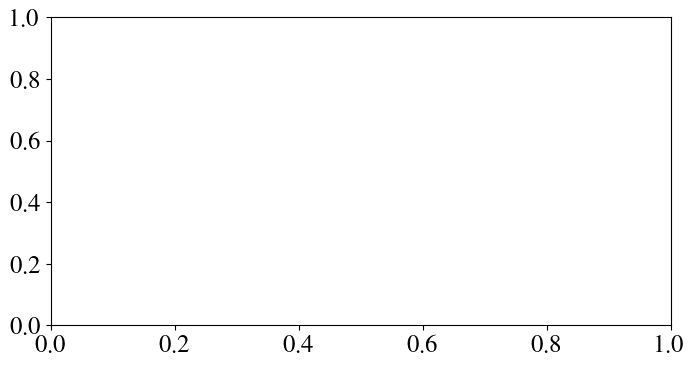

In [ ]:
plt.figure(figsize=(8, 4))
plt.hist(expansion_factors_full, bins=50, color="darkblue", edgecolor="white")

plt.xlabel("Facteur d’expansion")
plt.ylabel("Nombre de lignes")
plt.title("Distribution du facteur d’expansion magnétique")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.cm as cm
import matplotlib.colors as colors
import numpy as np
from astropy.coordinates import SkyCoord
import astropy.units as u

factors_grouped = []
i = 0
for flines in flines_list_full:
    n = len(flines.field_lines)
    factors_grouped.append(expansion_factors_full[i:i+n])
    i += n

factors_float = np.array([f.value if hasattr(f, 'value') else f for f in expansion_factors_full])

# Colormap
cmap = plt.cm.plasma
norm = colors.Normalize(vmin=np.nanmin(factors_float), vmax=np.nanmax(factors_float))

#Zone de zoom
# Définir la zone de zoom
min_lon = np.min(rotated_arcsec_contours[3].Tx.to_value(u.arcsec))
max_lon = np.max(rotated_arcsec_contours[3].Tx.to_value(u.arcsec))

min_la = np.min(rotated_arcsec_contours[3].Ty.to_value(u.arcsec))
max_la = np.max(rotated_arcsec_contours[3].Ty.to_value(u.arcsec))
x_start = (min_lon - 3500) * u.arcsec
x_end   = (max_lon + 1000) * u.arcsec
y_start = (min_la - 1500 ) * u.arcsec
y_end   = (max_la + 4000) * u.arcsec

# x_start = (min_lon - 500) * u.arcsec
# x_end   = (max_lon + 500) * u.arcsec
# y_start = (min_la - 500) * u.arcsec
# y_end   = (max_la + 500) * u.arcsec


bottom_left = SkyCoord(x_start, y_start, frame=fsi_map.coordinate_frame)
top_right = SkyCoord(x_end, y_end, frame=fsi_map.coordinate_frame)
bl_px = fsi_map.wcs.world_to_pixel(bottom_left)
tr_px = fsi_map.wcs.world_to_pixel(top_right)

# Création figure
fig = plt.figure(figsize=(8, 8))
ax = plt.subplot(1, 1, 1, projection=fsi_map)
fsi_map.plot(axes=ax)
ax.set_xlim(bl_px[0], tr_px[0])
ax.set_ylim(bl_px[1], tr_px[1])

# Tracer les lignes avec couleurs selon facteur
for flines, fgroup in zip(flines_list_full, factors_grouped):
    for fl, f in zip(flines.field_lines[::5], fgroup[::5]):  # Ajuste le pas ici
        if np.isnan(f):
            continue
        f_val = f.value if hasattr(f, 'value') else f
        color = cmap(norm(f_val))
        ax.plot_coord(fl.coords, color=color, linewidth=1.2, alpha=0.9)


for contour in arcsec_contours:
    ax.plot_coord(contour, color='blue', linewidth=1.5)
for zone in zone_list:
    ax.plot_coord(zone, color='white', marker='o', linewidth=0, markersize=1.5)
    
# Ajout de la colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Nécessaire pour que la colorbar fonctionne sans image
cbar = plt.colorbar(sm, ax=ax, pad=0.05)
cbar.set_label("Facteur d'expansion")

plt.tight_layout()
plt.show()

/tmp/ipykernel_3082412/404354800.py:20: RuntimeWarning: All-NaN slice encountered
  norm = colors.Normalize(vmin=np.nanmin(factors_float), vmax=np.nanmax(factors_float))


IndexError: list index out of range

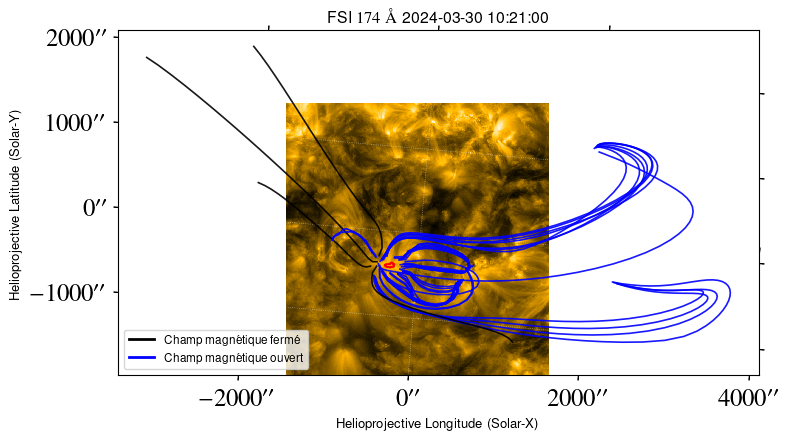

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
from astropy.coordinates import SkyCoord
import astropy.units as u

# min_lon = np.min(rotated_arcsec_contours[3].Tx.to_value(u.arcsec))
# max_lon = np.max(rotated_arcsec_contours[3].Tx.to_value(u.arcsec))

# min_la = np.min(rotated_arcsec_contours[3].Ty.to_value(u.arcsec))
# max_la = np.max(rotated_arcsec_contours[3].Ty.to_value(u.arcsec))


# Définir la zone de zoom

# # Définir la zone de zoom AIA
# x_start = -1000 * u.arcsec
# x_end   = 1100 * u.arcsec
# y_start = -1000 * u.arcsec
# y_end   = 300 * u.arcsec

# #Zone de zoom FSI
# x_start = -3000 * u.arcsec
# x_end   = 3000 * u.arcsec
# y_start = -2000 * u.arcsec
# y_end   = 2000 * u.arcsec

# bottom_left = SkyCoord(x_start, y_start, frame=fsi_map.coordinate_frame)
# top_right = SkyCoord(x_end, y_end, frame=fsi_map.coordinate_frame)
# bl_px = fsi_map.wcs.world_to_pixel(bottom_left)
# tr_px = fsi_map.wcs.world_to_pixel(top_right)

# Création figure
# Appliquer les limites en pixels

plt.figure(figsize=(8, 6))
ax = plt.subplot(1, 1, 1, projection=sub_map)
sub_map.plot(axes=ax)

# ax.set_xlim(bl_px[0], tr_px[0])
# # ax.set_ylim(bl_px[1], tr_px[1])
# ax.set_xlim(-2000,2000)
# ax.set_ylim(-2000, 4000)

# Tracer les lignes ouvertes et fermées
for flines in flines_list_full[::5]:
    for fl in flines.field_lines:
        if fl.coords is None or fl.coords.shape[0] == 0:
            continue  # ignorer les lignes vides
        # if fl.coords.shape[-1] != 2:
        #     continue  # ignorer les coordonnées non conformes (doivent être Nx2)
        color = 'black' if fl.is_open else 'blue'
        ax.plot_coord(fl.coords, color=color, linewidth=1.2, alpha=0.9)


for contour in arcsec_contours:
    ax.plot_coord(contour, color='red', linewidth=1.5)

# for zone in zone_list:
#     ax.plot_coord(zone, color='white', marker='o', linewidth=0, markersize=1.5)
# Légende
legend_elements = [
    Line2D([0], [0], color='black', lw=2, label='Champ magnétique fermé'),
    Line2D([0], [0], color='blue', lw=2, label='Champ magnétique ouvert'),
]

ax.legend(handles=legend_elements, loc='lower left', fontsize=9)

#plt.title("Lignes de champ : ouvertes (vertes) vs fermées (blanches)")
plt.tight_layout()
#plt.savefig('/home/wmouici/stage/data/pfss_in_3003.pdf')
plt.show()


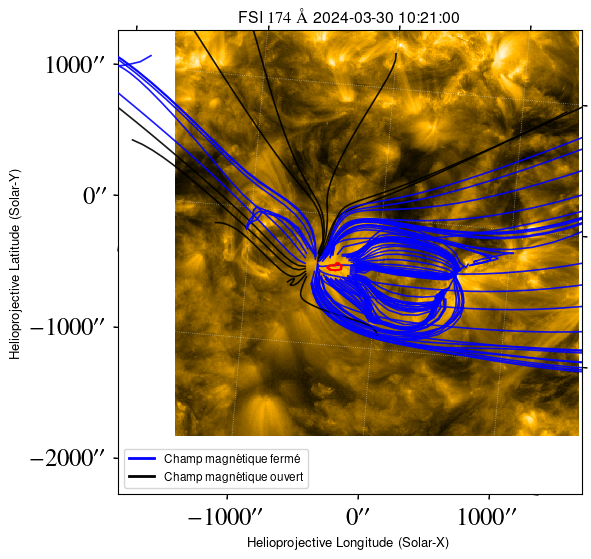

In [ ]:
plt.figure(figsize=(6, 6))  # carré
ax = plt.subplot(1, 1, 1, projection=sub_map)
sub_map.plot(axes=ax)

# Exemple : recadrage plus serré en arcsec
x_min, x_max = -100, 700  # en arcsec
y_min, y_max = -100, 700

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

# Tracés
for flines in flines_list_full[::2]:
    for fl in flines.field_lines:
        if fl.coords is None or fl.coords.shape[0] == 0:
            continue
        color = 'black' if fl.is_open else 'blue'
        ax.plot_coord(fl.coords, color=color, linewidth=1.2, alpha=0.9)

for contour in arcsec_contours:
    ax.plot_coord(contour, color='red', linewidth=1.5)

legend_elements = [
    Line2D([0], [0], color='blue', lw=2, label='Champ magnétique fermé'),
    Line2D([0], [0], color='black', lw=2, label='Champ magnétique ouvert'),
]
ax.legend(handles=legend_elements, loc='lower left', fontsize=9)
plt.savefig('/home/wmouici/stage/data/pfss_out_3003.pdf')
plt.tight_layout()
plt.show()


### Plot des FOV

2025-06-03 11:57:08 - sunpy - WARNING: SunpyUserWarning: This file contains more than 2 dimensions. Data will be truncated to the first two dimensions.


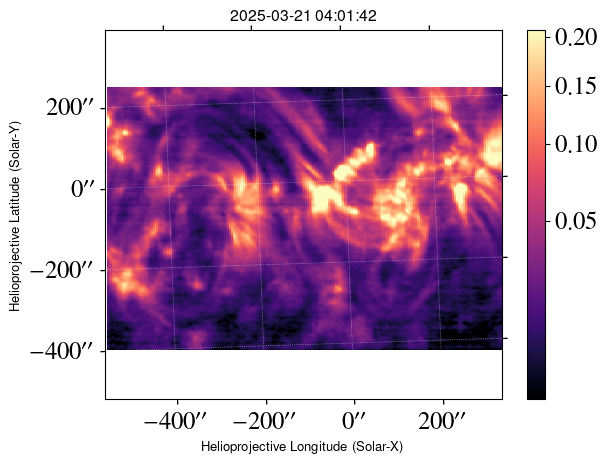

In [ ]:
import astropy 

raster = SPICEL3Raster(folder_path="/home/wmouici/stage/data/saffron_run_results_2025_conv_last_version_corrige/solo_L2.5_spice-n-ras_20250321T040142_V04_318767203-000_0600")
radiance_mg = raster.find_line(706).get_map("rad",remove_dumbells=True)
norm = astropy.visualization.mpl_normalize.ImageNormalize(radiance_mg.data,
                      interval=AsymmetricPercentileInterval(1, 99),
                      stretch=astropy.visualization.SqrtStretch()
                     )
radiance_mg.plot_settings['cmap'] = plt.get_cmap('magma')
radiance_mg.plot_settings['norm'] = norm
radiance_mg.plot(norm=norm, aspect='auto')
plt.colorbar()

2025-06-03 11:57:13 - sunpy - WARNING: SunpyUserWarning: This file contains more than 2 dimensions. Data will be truncated to the first two dimensions.


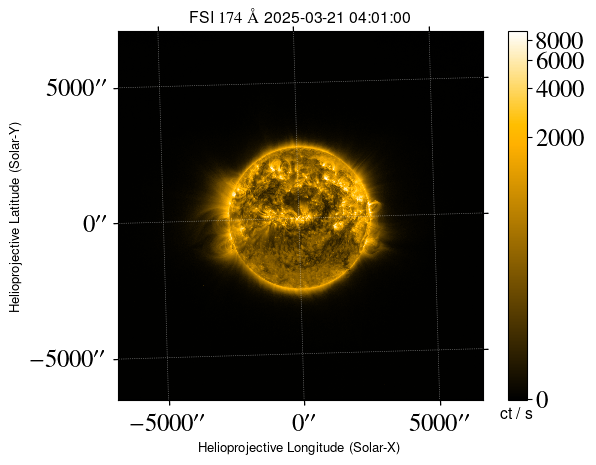

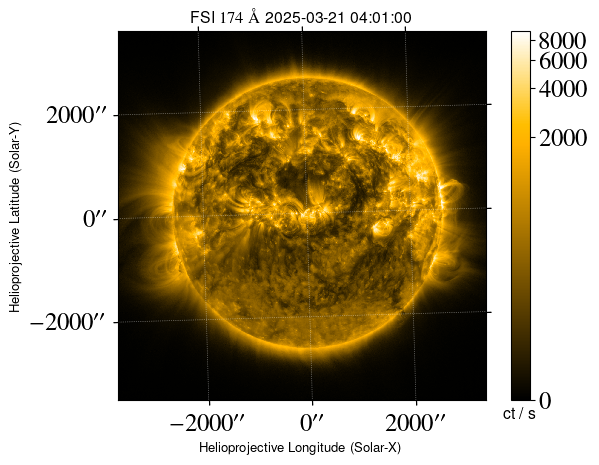

In [ ]:
import os.path
from euispice_coreg.hdrshift.alignment import Alignment
import numpy as np
from euispice_coreg.plot.plot import PlotFunctions
from euispice_coreg.utils.Util import AlignCommonUtil
from pathlib import Path
import astropy.units as u
from getmap import to_submap

path_fsi = Path("/home/wmouici/stage/data/solo_L2_eui-fsi174-image_20250321T040055261_V00.fits")
path_hri = Path("/home/wmouici/stage/data/saffron_run_results_2025_conv_new_version/solo_L2.5_spice-n-ras_20250321T040142_V04_318767203-000_0000/00706.02-mg_9.fits")
if True:
     from astropy.io import fits
     from sunpy.map import Map
     fsi_map = Map(path_fsi)
     
     tmp_path = Path("./tmp/")
     tmp_path.mkdir(exist_ok=True)
     hdul = fits.open(path_hri)
     data = hdul[0].data*hdul[2].data
     map_ = Map([data,hdul[0].header])
     sub_map_bis = to_submap(target_map=fsi_map,source_map=map_,expand=[3000,3000]*u.arcsec)
     #sub_map.save(tmp_path/path_fsi.name,overwrite=True)
     # map_.save(tmp_path/path_hri.name,overwrite=True)
     # path_hri = str(tmp_path/path_hri.name)
     # path_fsi = str(tmp_path/path_fsi.name)

fsi_map.peek()
sub_map_bis.peek()

In [ ]:
from pathlib import Path
from astropy.io import fits
from sunpy.map import Map
path_fsi = Path("/home/wmouici/stage/data/solo_L2_eui-fsi174-image_20250321T040055261_V00.fits")
path_hri = Path("/home/wmouici/stage/data/saffron_run_results_2025_conv_new_version/solo_L2.5_spice-n-ras_20250321T040142_V04_318767203-000_0000/00706.02-mg_9.fits")
fsi_map = Map(path_fsi)

In [ ]:
def rotate_coords(mmap, rtime):
    bl = SkyCoord(mmap.bottom_left_coord.Tx, mmap.bottom_left_coord.Ty, frame=mmap.coordinate_frame)
    tr = SkyCoord(mmap.top_right_coord.Tx, mmap.top_right_coord.Ty, frame=mmap.coordinate_frame)

    bl_diff = sunpy.coordinates.metaframes.RotatedSunFrame(base=bl, rotated_time=rtime)
    tr_diff = sunpy.coordinates.metaframes.RotatedSunFrame(base=tr, rotated_time=rtime)

    bl_diffrot = bl_diff.transform_to(mmap.coordinate_frame)
    tr_diffrot = tr_diff.transform_to(mmap.coordinate_frame)

    bl = SkyCoord(bl_diffrot.Tx.value, bl_diffrot.Ty.value, frame=mmap.coordinate_frame, unit=u.arcsec)
    tr = SkyCoord(tr_diffrot.Tx.value, tr_diffrot.Ty.value, frame=mmap.coordinate_frame, unit=u.arcsec)

    return bl, tr


In [ ]:
spice_bl, spice_tr = rotate_coords(radiance_mg, rtime=aia.date)
eui_fsi_map_bl, eui_fsi_map_tr = rotate_coords(fsi_map, rtime=aia.date)

2025-06-03 11:57:26 - sunpy - WARNING: SunpyUserWarning: The conversion of these 2D helioprojective coordinates to 3D is all NaNs because off-disk coordinates need an additional assumption to be mapped to calculate distance from the observer. Consider using the context manager `Helioprojective.assume_spherical_screen()`.


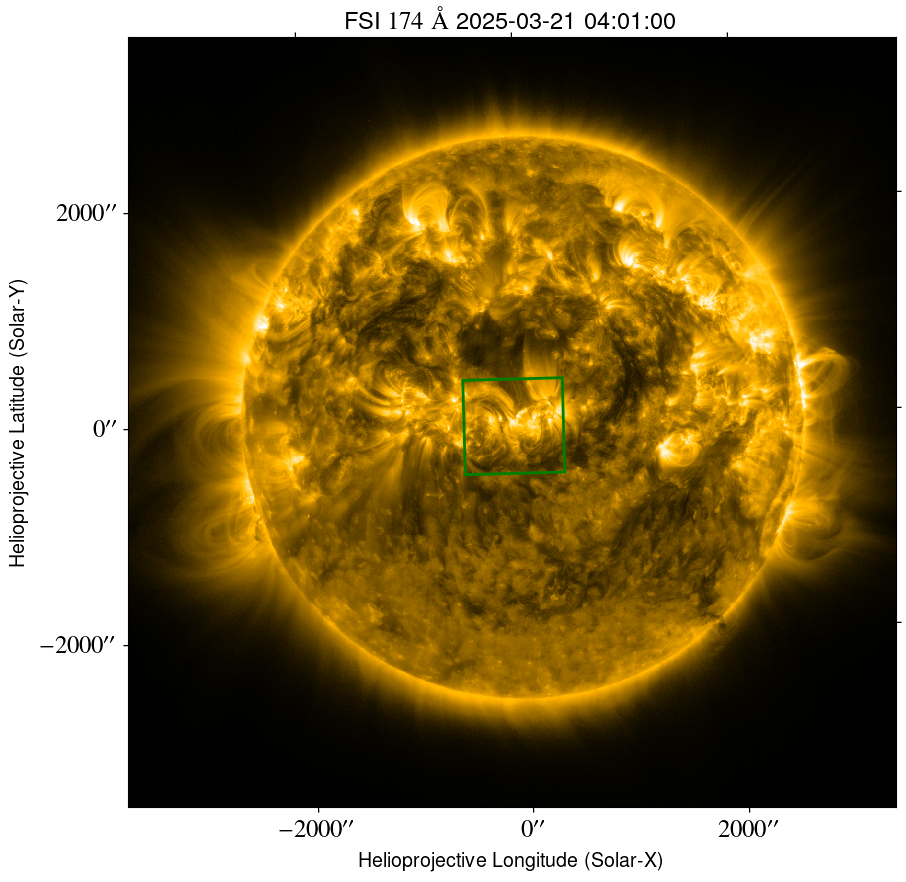

In [ ]:
# Plot the FOVs of EUI/HRI, PHI/HRT, and SPICE on AIA 193 map
plt.rc("font",size=15)
fig = plt.figure(figsize=(10,10))

ax1 = plt.subplot(111, projection=sub_map_bis)
ax1.grid(False)
sub_map_bis.plot(axes=ax1, clip_interval=(1, 99.99)*u.percent)

radiance_mg.draw_quadrangle(spice_bl, top_right=spice_tr, axes=ax1, edgecolor='green', lw=2)
#fsi_map.draw_quadrangle(eui_fsi_map_bl, top_right=eui_fsi_map_tr, axes=ax1, edgecolor='blue', lw=2)
ax1.grid(False)

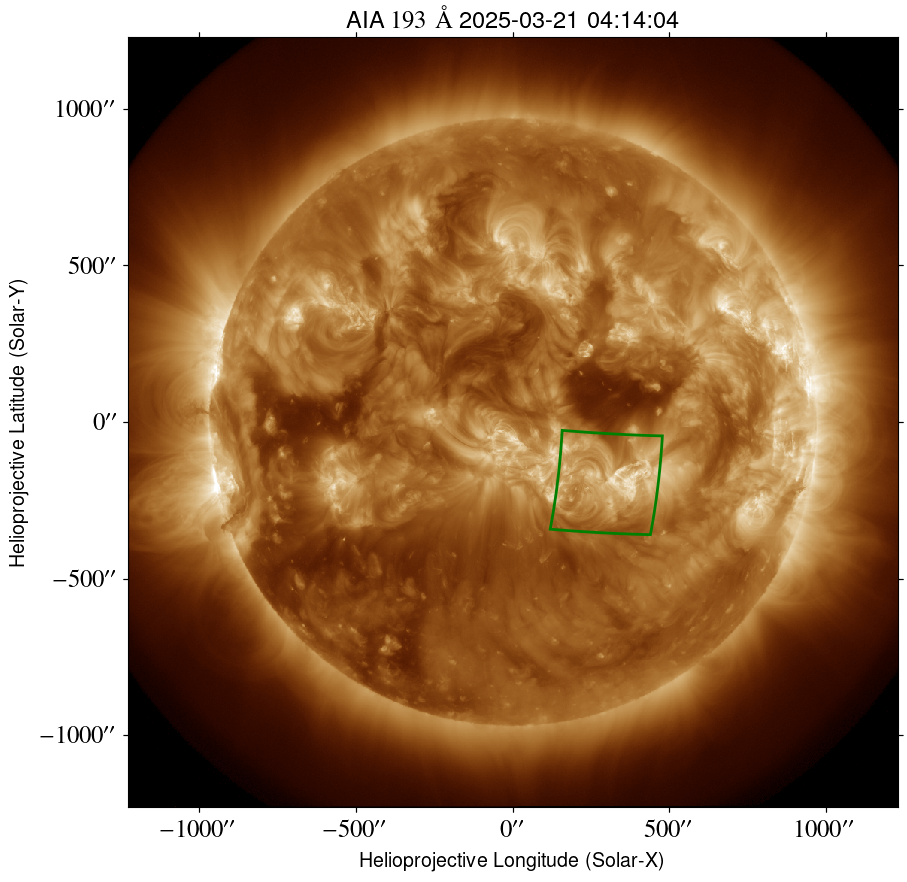

In [ ]:
# Plot the FOVs of EUI/HRI, PHI/HRT, and SPICE on AIA 193 map
plt.rc("font",size=15)
fig = plt.figure(figsize=(10,10))

ax1 = plt.subplot(111, projection=aia)
ax1.grid(False)
aia.plot(axes=ax1, clip_interval=(1, 99.99)*u.percent)

radiance_mg.draw_quadrangle(spice_bl, top_right=spice_tr, axes=ax1, edgecolor='green', lw=2)
fsi_map.draw_quadrangle(eui_fsi_map_bl, top_right=eui_fsi_map_tr, axes=ax1, edgecolor='black', lw=2)
ax1.grid(False)